In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(binom)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


# Lineage assignment (Mez2 vs A00 vs chimp)

In [2]:
mh <- "a00"

In [3]:
df <- read_genotypes("mez2", "full", mindp = 3, maxdp = 0.975, tv_only = TRUE) %>%
    select(chrom, pos, REF, ALT, mez2, chimp, !!mh) %>%
    filter(complete.cases(.))

In [4]:
head(df)

chrom,pos,REF,ALT,mez2,chimp,a00
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Y,2649827,G,,0,0,0
Y,2649828,T,,0,0,0
Y,2649829,T,,0,0,0
Y,2649830,A,,0,0,0
Y,2649831,A,,0,0,0
Y,2649832,T,,0,0,0


In [5]:
props %<-% future_map_dfr(c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2"), function(arch) {
    capture <- ifelse(arch == "elsidron2", "lippold", "full")

    arch_df <- read_vcf(here(paste0("data/vcf/", capture, "_", arch, ".vcf.gz")), mindp = 3, maxdp = 0.975)
    joined <- inner_join(df, arch_df, by = c("chrom", "pos", "REF")) %>% filter(ALT.y == "" | ALT.x == ALT.y)

    joined <- filter(joined, complete.cases(joined))

    tibble(
        hum   = sum(joined[["mez2"]] == joined[["chimp"]] & joined[[mh]] != joined[["mez2"]]  & joined[[arch]] == joined[[mh]]),
        neand = sum(joined[[mh]]  == joined[["chimp"]] & joined[[mh]] != joined[["mez2"]]  & joined[[arch]] == joined[["mez2"]]),
        anc   = sum(joined[["mez2"]] == joined[[mh]]   & joined[[mh]] != joined[["chimp"]] & joined[[arch]] == joined[["chimp"]]),
        total = hum + neand + anc
    ) %>%
        gather(lineage, count, -total) %>%
        mutate(
            name = arch,
            map2(count, total, ~ binom.confint(.x, .y, methods = "exact") %>%
                                     select(mean, lower, upper))) %>%
        unnest %>%
        select(name, everything())
})

In [6]:
props

name,total,lineage,count,mean,lower,upper
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
den4,114,hum,1,0.00877193,0.0002220614,0.04790526
den4,114,neand,1,0.00877193,0.0002220614,0.04790526
den4,114,anc,112,0.98245614,0.9380613068,0.99786825
den8,358,hum,6,0.01675978,0.0061747467,0.03612030
den8,358,neand,10,0.02793296,0.0134744943,0.05076855
den8,358,anc,342,0.95530726,0.9284349937,0.97424169
spy1,19,hum,1,0.05263158,0.0013316288,0.26028065
spy1,19,neand,18,0.94736842,0.7397193458,0.99866837
spy1,19,anc,0,0.00000000,0.0000000000,0.17646691


Both Denisovan Y chromosomes fall with close to 100% certainty to a branch ancestral to AMH and Neanderthals.

The small number of sites falling on human or Neanderthal branches is easily explained by DNA damage - a truly ancestral site carrying a damage substitution will flip with 50% probability to one or the other, which is what we see for both Denisova 4 and Denisova 8.

In [11]:
plot_lineages <- function(df, archaic) {
    par(mar = c(1, 1, 1, 1))

    stopifnot(archaic %in% df$name)

    name <- case_when(
        archaic == "den8" ~ "Denisova 8",
        archaic == "den4" ~ "Denisova 4",
        archaic == "spy1" ~ "Spy 1",
        archaic == "mez2" ~ "Mezmaiskaya 2",
        archaic == "elsidron2" ~ "El Sidrón 1253",
        archaic == "shotgun_spy1" ~ "Spy 1 (shotgun)",
        archaic == "shotgun_mez2" ~ "Mazmaiskaya 2 (shotgun)"
    )

    anc <- filter(df, name == archaic, lineage == "anc")[, c("mean", "lower", "upper")] * 100
    hum <- filter(df, name == archaic, lineage == "hum")[, c("mean", "lower", "upper")] * 100
    neand <- filter(df, name == archaic, lineage == "neand")[, c("mean", "lower", "upper")] * 100

    count_anc <- filter(df, name == archaic, lineage == "anc")$count
    count_hum <- filter(df, name == archaic, lineage == "hum")$count
    count_neand <- filter(df, name == archaic, lineage == "neand")$count

    total <- filter(df, name == archaic)$total[1]

    plot(0, main = name, axes = FALSE, xaxs="i", yaxs="i", type = "n", xlab = "", ylab = "", xlim = c(0, 10), ylim = c(0, 10))

    if (anc[1] > hum[1] & anc[1] > neand[1]) {
        rect(9.4, 7.5, 5.4, 6, border = "darkgreen")
        w <- list(anc = 7, hum = 1, neand = 1)
        a <- list(anc = 1, hum = 0.25, neand = 0.25)
        segments(x0 = 8.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkred", lend = "round", lwd = w$hum)
        segments(x0 = 1.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkblue", lend = "round", lwd = w$neand)
        segments(x0 = 5, x1 = 5, y0 = 4, y1 = 8.5, col = "darkgreen", lend = "round", lwd = w$anc)
    } else {
        rect(4, 3.8, 0.01, 5.3, border = "darkblue")
        w <- list(anc = 1, hum = 1, neand = 7)
        a <- list(anc = 0.25, hum = 0.25, neand = 1)
        segments(x0 = 8.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkred", lend = "round", lwd = w$hum)
        segments(x0 = 5, x1 = 5, y0 = 4, y1 = 8.5, col = "darkgreen", lend = "round", lwd = w$anc)
        segments(x0 = 1.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkblue", lend = "round", lwd = w$neand)
    }

    text(5, 9.5, "\nancestral", col = "darkgreen")
    text(7.4, 6.8, sprintf("%.1f%% [%.1f - %.1f]\n%d out of %d sites", anc[1], anc[2], anc[3], count_anc, total),
         col = alpha("darkgreen", a$anc))

    text(1.5, 0.8, "Mezmaiskaya 2", col = "darkblue")
    text(2, 4.5, sprintf("%.1f%% [%.1f - %.1f]\n%d out of %d sites", neand[1], neand[2], neand[3], count_neand, total),
         col = alpha("darkblue", a$neand))

    text(8.5, 0.8, "A00", col = "darkred")
    text(7.8, 4.5, sprintf("%.1f%% [%.1f - %.1f]\n%d out of %d sites", hum[1], hum[2], hum[3], count_hum, total),
         col = alpha("darkred", a$hum))

}

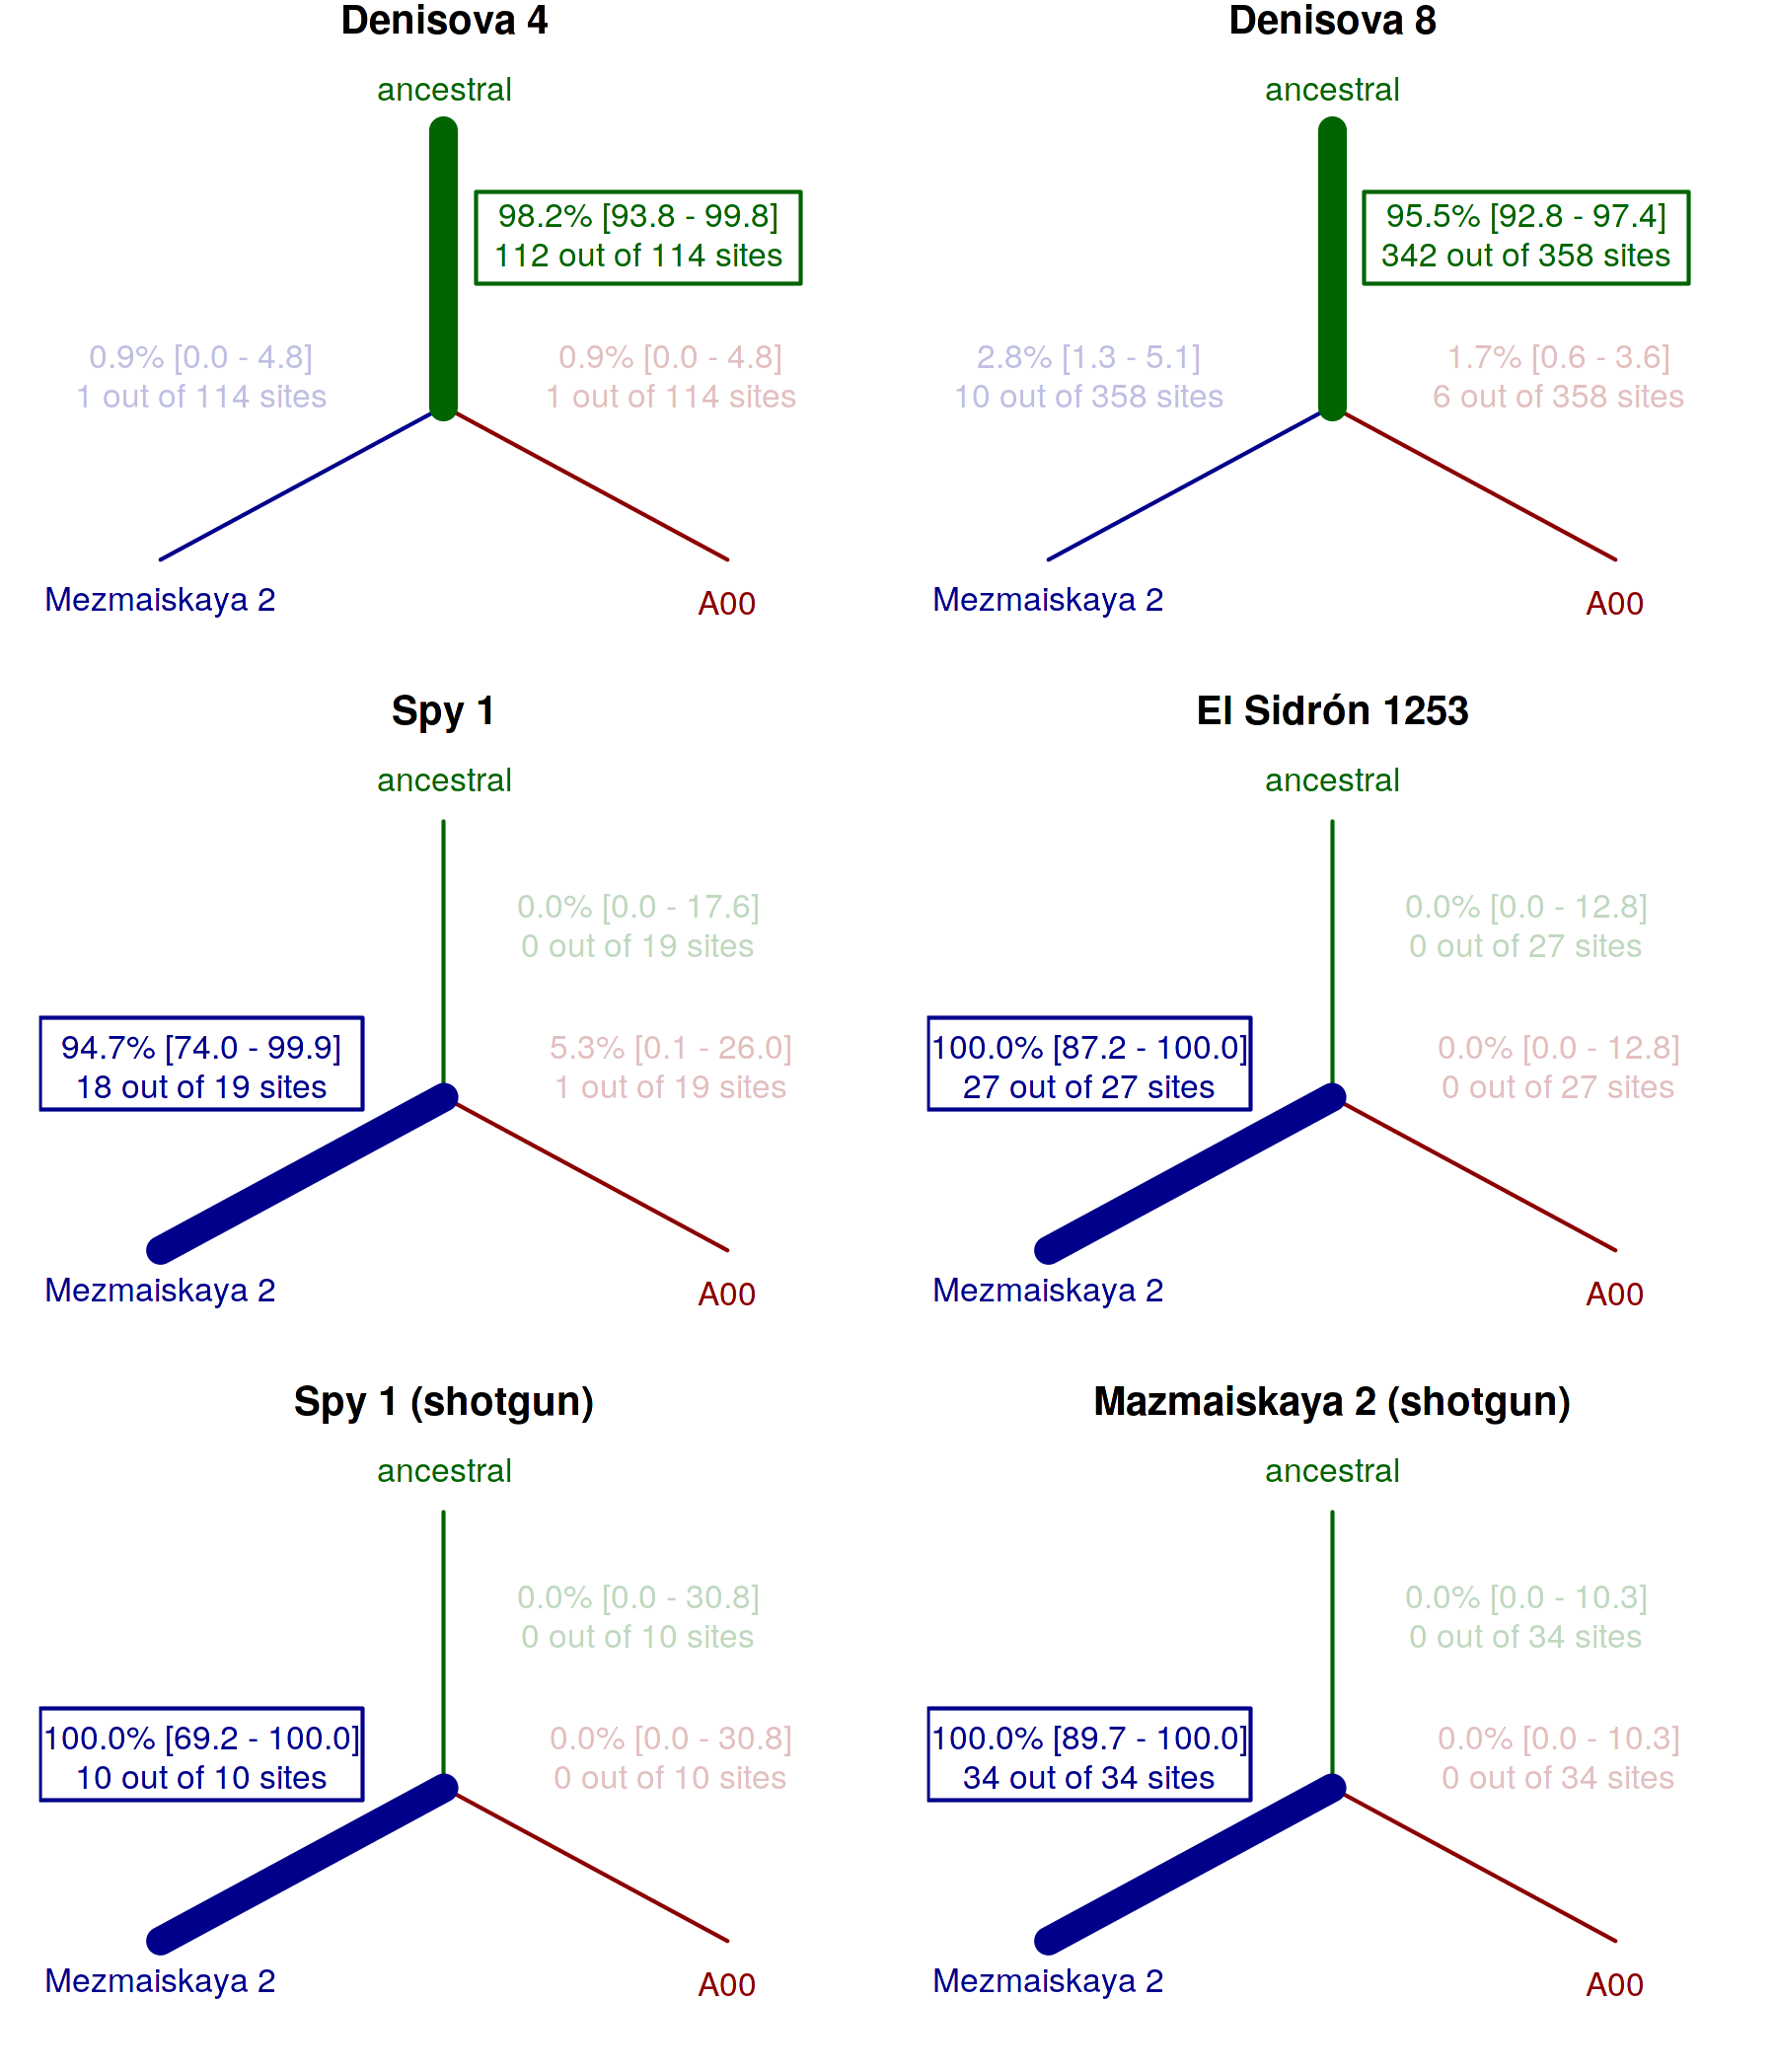

In [12]:
set_dim(6, 7)

par(mfrow = c(3, 2))

for (arch in c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2")) {
    plot_lineages(props, arch)
}

In [38]:
png(here("figures/lineage_assignment.png"), width = 2000, height = 2400, res = 300)

par(mfrow = c(3, 2))
par(mar = c(1 , 1, 1, 1))

for (arch in c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2")) {
    plot_lineages(props, arch)
}

dev.off()

png 
  2